# Практика PyTorch
Используя PyTorch, создать и обучить нейросеть, которая аппроксимирует значение функции sin(x + 2*y)exp(-(2x + y)^2) на диапазоне значений [-10;10] по х и у. <br><br>
В качестве обучающей выборки необходимо сгенерировать 20000 точек случайным образом. <br><br>
Разделить получившийся датасет на train / test / val в отношениях 70% / 15% / 15%, соответственно. <br><br>
Результаты:
- a) Посчитать метрику Mean Square Error(MSE) на test.
- b) Нарисовать график, в котором сравнивается истинная функция и ее аппроксимированный вариант (предсказываемый моделью)

In [ ]:
# MSE tourch

loss = nn.MSELoss()
input = torch.randn(3, 5, requires_grad=True) 
target = torch.randn(3, 5) # 
output = loss(input, target)
output.backward()

In [ ]:
# генерация tourch

torch.randint(low, high, (size,) ...) # N(size) random numbers for low (inclusive) to high (exclusive)
torch.rand(size, ...) # random numbers from a uniform distribution [0:1]
torch.linspace(start, end, steps,) # N(steps) whose values are evenly spaced from start to end, inclusive

In [ ]:
# train-test split tourch

torch.utils.data.random_split(dataset, lengths)
https://discuss.pytorch.org/t/how-to-split-dataset-into-test-and-validation-sets/33987

In [ ]:
torch.exp()
torch.sin()
torch.square()

In [1]:
import numpy as np
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import random
import math
import tqdm
import copy

In [2]:
import copy

In [71]:
x = torch.randint(-10, 11, (1000,))
y = torch.randint(-10, 11, (1000,))



sin(x + 2*y)exp(-(2x + y)^2)

In [6]:
torch.exp(-2*((2*x)@y))

tensor(6.0546e-39)

квадрат суммы: $(а + b)^2 = а^2 + 2аb + b^2$ <br><br>
экспонента суммы: $e^{A+B} = e^A * e^B$ <br><br>
синус суммы: sin(α + β) = sin(α) * cos(β) + cos(α) * sin(β) 

In [72]:
# разложим sin-часть
sin = (torch.sin(x) * torch.cos(2*y)) + (torch.cos(x) * torch.sin(2*y))

In [73]:
# разложим exp-часть
exp = torch.exp(-torch.square(2*x)) + torch.exp(-2*((2*x)@y)) + torch.exp(-torch.square(y))

In [74]:
# проверим размер
print(sin.shape)


torch.Size([1000])


In [75]:
# проверим размер
print(exp.shape)


torch.Size([1000])


In [76]:
z = sin*exp

In [ ]:
# таргет
z = (torch.sin(x) * torch.cos(2*y)) + (torch.cos(x) * torch.sin(2*y))@(torch.exp(-torch.square(2*x)) + torch.exp(-2*((2*x)@y)) + torch.exp(-torch.square(y)))

In [69]:
z.shape

torch.Size([1000])

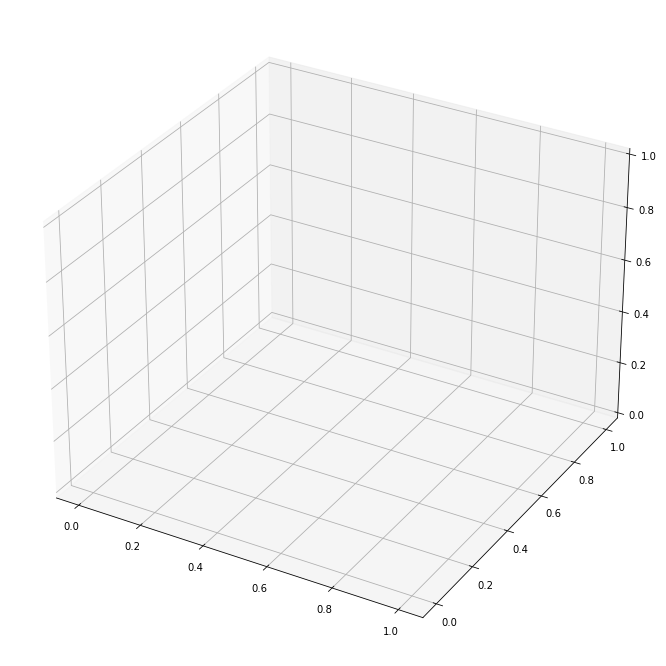

In [77]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
ax.scatter(x, y, z)
plt.show()

In [14]:
# объединим х и у в 2d тензор признаков, чтобы положить его в dataloader
xy = torch.stack((x,y), -1)

In [15]:
my_dataset = TensorDataset(xy,z) # создали datset
my_dataloader = DataLoader(my_dataset) # создали dataloader

In [16]:
# train_test_split в torch
train, test = torch.utils.data.random_split(my_dataset, [700, 300])
test, val = torch.utils.data.random_split(test, [150, 150])

# взять x,y из train, test, val
X_train, y_train = train[:]
X_test, y_test = test[:]
X_val, y_val = val[:]



In [17]:
print('X_train:', X_train.dtype)
print('y_train:', y_train.dtype)

X_train: torch.int64
y_train: torch.float32


In [18]:
# приведем к одному формату
# X к float32
 
X_train = X_train.to(torch.float32)
X_test = X_test.to(torch.float32)
X_val = X_val.to(torch.float32)

In [19]:
print('X_train:', X_train.dtype)
print('y_train:', y_train.dtype)

X_train: torch.float32
y_train: torch.float32


In [20]:
# модель
model = nn.Sequential(
    nn.Linear(2, 50),
    nn.ReLU(),
    nn.Linear(50, 25),
    nn.ReLU(),
    nn.Linear(25, 5),
    nn.ReLU(),
    nn.Linear(5, 1)
)

# loss function and optimizer
loss_fn = nn.MSELoss()  # mean square error
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [54]:
# training parameters
n_epochs = 50   # number of epochs to run
batch_size = 100  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)
 
# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []
 
# training loop
for epoch in range(n_epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    model.train()
    with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
            print(f"loss: {loss}  [{[start+batch_size]}/{len(X_train)}]")
    # evaluate accuracy at end of each epoch on validation
    model.eval()
    y_pred = model(X_val)
    mse = loss_fn(y_pred, y_val)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())
 
# restore model and return best accuracy
model.load_state_dict(best_weights)

Epoch 1
-------------------------------
loss: 0.09434360265731812  [[tensor(100)]/700]
loss: 0.09540408849716187  [[tensor(200)]/700]
loss: 0.04949965700507164  [[tensor(300)]/700]
loss: 0.057269200682640076  [[tensor(400)]/700]
loss: 0.10039005428552628  [[tensor(500)]/700]
loss: 0.07476110011339188  [[tensor(600)]/700]
loss: 0.0375690683722496  [[tensor(700)]/700]
Epoch 2
-------------------------------
loss: 0.0671023428440094  [[tensor(100)]/700]
loss: 0.06903263926506042  [[tensor(200)]/700]
loss: 0.0316351056098938  [[tensor(300)]/700]
loss: 0.046424973756074905  [[tensor(400)]/700]
loss: 0.08851933479309082  [[tensor(500)]/700]
loss: 0.06767642498016357  [[tensor(600)]/700]
loss: 0.0322038009762764  [[tensor(700)]/700]
Epoch 3
-------------------------------
loss: 0.06610661000013351  [[tensor(100)]/700]
loss: 0.06757614761590958  [[tensor(200)]/700]
loss: 0.030283385887742043  [[tensor(300)]/700]
loss: 0.045191820710897446  [[tensor(400)]/700]
loss: 0.08588097989559174  [[tenso

loss: 0.03893018886446953  [[tensor(400)]/700]
loss: 0.07844435423612595  [[tensor(500)]/700]
loss: 0.060161273926496506  [[tensor(600)]/700]
loss: 0.024753667414188385  [[tensor(700)]/700]
Epoch 25
-------------------------------
loss: 0.06184205785393715  [[tensor(100)]/700]
loss: 0.061439331620931625  [[tensor(200)]/700]
loss: 0.024011772125959396  [[tensor(300)]/700]
loss: 0.038914382457733154  [[tensor(400)]/700]
loss: 0.07839461416006088  [[tensor(500)]/700]
loss: 0.06014313921332359  [[tensor(600)]/700]
loss: 0.024729952216148376  [[tensor(700)]/700]
Epoch 26
-------------------------------
loss: 0.061856988817453384  [[tensor(100)]/700]
loss: 0.06143122538924217  [[tensor(200)]/700]
loss: 0.02399742789566517  [[tensor(300)]/700]
loss: 0.03889923542737961  [[tensor(400)]/700]
loss: 0.0783439427614212  [[tensor(500)]/700]
loss: 0.06012653931975365  [[tensor(600)]/700]
loss: 0.02470833994448185  [[tensor(700)]/700]
Epoch 27
-------------------------------
loss: 0.06186832115054130

<All keys matched successfully>

MSE: 0.06


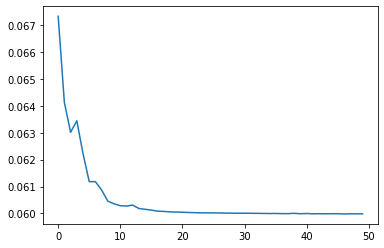

In [55]:
# restore model and return best accuracy
model.load_state_dict(best_weights)
print("MSE: %.2f" % best_mse)
plt.plot(history)
plt.show()

In [24]:
# проверим модель на тесте 
 
model.eval()
y_test_pred = model(X_test)
mse = loss_fn(y_test_pred, y_test)

In [26]:
print(f'mse сети на тестовой выборке:{round(float(mse), 2)}')

mse сети на тестовой выборке:0.11


In [27]:
# возьмем первый столбц элементов из 2d тензора - то, что было x
X_test[:, 0].shape

torch.Size([150])

In [28]:
# возьмем второй столбц элементов из 2d тензора - то, что было y
X_test[:, 1].shape

torch.Size([150])

In [34]:
y_test_pred.shape

torch.Size([150, 1])

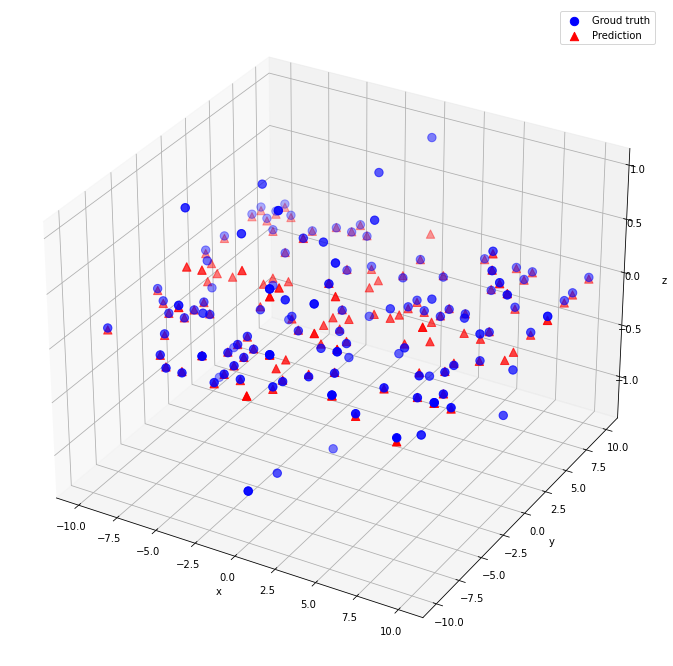

In [29]:
# 3d scatter 
 
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
ax.scatter(X_test[:, 0], X_test[:, 1], y_test, s=70, color='blue', label='Groud truth', marker='o')
ax.scatter(X_test[:, 0], X_test[:, 1], y_test_pred[:, 0].detach().numpy(), s=70, color='red', label='Prediction', marker='^')
ax.legend()
ax.tick_params(axis="z", pad=-3)
ax.set_xlabel("x")
ax.set_ylabel("y",)
ax.set_zlabel("z")
plt.show()

In [30]:
print('X_train:', X_train.dtype, X_train.shape)
print('y_train:', y_train.dtype, y_train.shape)

X_train: torch.float32 torch.Size([700, 2])
y_train: torch.float32 torch.Size([700])


In [44]:
class NetSeq(nn.Module):
    def __init__(self):
        super(NetSeq, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(2, 50),
            nn.ReLU(),
            nn.Linear(50, 25),
            nn.ReLU(),
            nn.Linear(25, 5),
            nn.ReLU(),
            nn.Linear(5, 1)
        )

    def forward(self, x):
        x = self.linear_relu_stack(x)

        return x

net_seq = NetSeq()

In [39]:
print(net_seq)

NetSeq(
  (fc1): Linear(in_features=2, out_features=50, bias=True)
  (act1): ReLU()
  (fc2): Linear(in_features=50, out_features=25, bias=True)
  (act2): ReLU()
  (fc3): Linear(in_features=25, out_features=5, bias=True)
  (act3): ReLU()
  (fc4): Linear(in_features=5, out_features=1, bias=True)
)


In [45]:
def predict(net, x, y):
    y_pred = net.forward(x)

    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(projection='3d')
    ax.scatter(x[:, 0], x[:, 1], y, s=70, color='blue', label='Groud truth', marker='o')
    ax.scatter(x[:, 0], x[:, 1], y_pred[:, 0].detach().numpy(), s=70, color='red', label='Prediction', marker='^')
    ax.legend()
    ax.tick_params(axis="z", pad=-3)
    ax.set_xlabel("x")
    ax.set_ylabel("y",)
    ax.set_zlabel("z")
    plt.show()



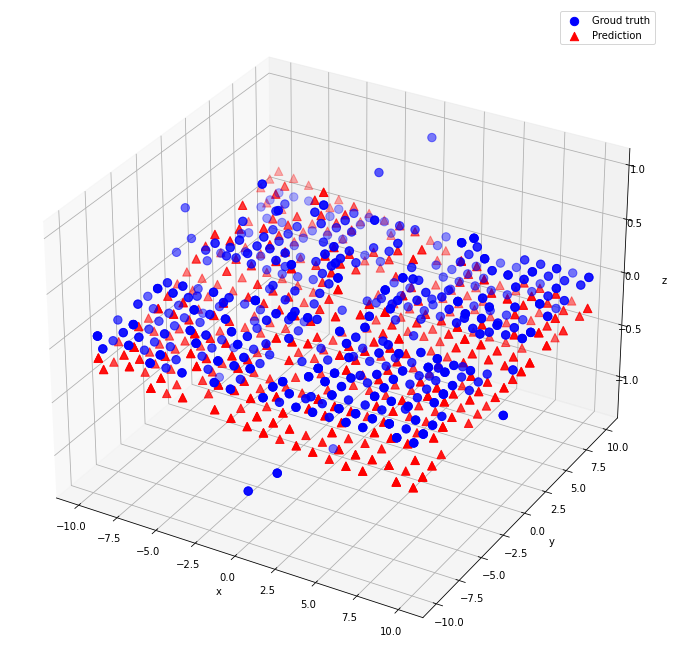

In [46]:
predict(net_seq, X_train, y_train)